# DTSA 5510 - Unsupervised Algorithms in Machine Learning Final Project
Chris Murphy 07/23/2024

## Introduction 

For my final project, I wanted to attempt to create a sentiment analysis model. As I was thinking about ideas for my project, I thought back to the BBC News Classification mini project we were tasked with completing in week 4 and was thinking about different areas of unsupervised machine learning algorithms that could be applied to the same dataset. In this project, the articles were classified into five distinct categories but what if a model could be bilt to understand if the document that was being analyzed was a positive story or a negative story? This was an interesting project idea that I wanted to learn more about. After some additional research, I found there are many methodogies to answer this same question in the broader sentiment analysis category.      

With my mind made up on undertaking an in depth sentiment analysis project, I needed some data to work with. I had found a few interesting datasets that contained scraped Twitter data on various topics, however, nothing really resonated with me. After thinking about the data I could use some more, I realized I had all the data I needed to copmlete a sentiment analysis project. In my day job as a Data Analyst for an e-commerce company, everday I'm working with transactional Amazon data. Sure enough, there was Amazon review data that I could query. This data would become my foundation for my final project.

The dataset contains 10,000 distinct reviews for users who had purchased items in various categories in the United States. A sample of the data can be viewed below. Here are the columns and a basic overview of what they indicate:

- ID: The unique identifier of the review
- REVIEW_DATE: The date when the review was left
- IS_VERIFIED: Whether or not the review was verified. (I did not end up using this column)
- RATING: The rating the user gave for the product on a 1 to 5 scale
- REVIEW_TITLE: The title of the review 
- REVIEW_TEXT: The review the user left for the product 
- NAME: The country the user is in

## Imports

In [1]:
# standard imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# sklearn specific imports
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import train_test_split

from nltk.tokenize import RegexpTokenizer

from langdetect import detect

from textblob import TextBlob

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

## Data import

In [2]:
# data import
reviews = pd.read_csv('data/reviews.csv')

## Basic data cleaning

In [3]:
# here is an initial view of a sample of rows in the dataset
reviews.sample(3)

,ID,REVIEW_DATE,IS_VERIFIED,RATING,REVIEW_TITLE,REVIEW_TEXT,NAME
422,5907129,2015-01-01,True,5,Five Stars,My 9yo loves this product. It also comes with ...,United States
1803,127575,2013-09-28,True,4,"Good product, but too expensive",I like this product it helped me when I chose ...,United States
4171,4937544,2019-02-16,True,5,Measure the chest properly,I bought this chest protector for my 9 year ol...,United States


In [4]:
# From the sample dataframe above, the 'NAME' field is misleading, it will be changed from 'NAME' to 'COUNTRY'
reviews.rename(columns={'NAME': 'COUNTRY'}, inplace = True)

In [5]:
# there are 10,000 reviews in our initial dataset.
# The 'REVIEW_TITLE' column has one null entry which we will remove in a subsequent cell
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ID            10000 non-null  int64 
 1   REVIEW_DATE   10000 non-null  object
 2   IS_VERIFIED   10000 non-null  bool  
 3   RATING        10000 non-null  int64 
 4   REVIEW_TITLE  9999 non-null   object
 5   REVIEW_TEXT   10000 non-null  object
 6   COUNTRY       10000 non-null  object
dtypes: bool(1), int64(2), object(4)
memory usage: 478.6+ KB


In [6]:
# Identifying the only row with a null value. Since we really care about the 'REVIEW_TEXT'
# this row could probably be left in but I will remove it just to be safe
reviews[reviews['REVIEW_TITLE'].isnull()]
reviews.dropna(subset = ['REVIEW_TITLE'], axis = 0, inplace = True)

In [7]:
# double checking that there are no more null values in the updated dataset
reviews.isnull().sum()

ID              0
REVIEW_DATE     0
IS_VERIFIED     0
RATING          0
REVIEW_TITLE    0
REVIEW_TEXT     0
COUNTRY         0
dtype: int64

In [8]:
# There are two more adjustments that need to be made. The 'REVIEW_DATE' column should be a datetime
# also the 'ID' field should be an object
reviews['REVIEW_DATE'] = pd.to_datetime(reviews['REVIEW_DATE'])
reviews['ID'] = reviews['ID'].astype(object)

### Removing non-english reviews

There is another issue that will impact our results later on in the model testing phase. Even though these reviews are sourced from Amazon.com, there are reviews that are in different languages. A mask will be created to filter our all non English reviews.

In [9]:
# The langdetect package can be used to detect the language of a body of text.
# the package can then be used in a basic function to return the particular language of the review.
def detect_language(text):
    try:
        lang = detect(text)
    except:
        lang = 'unknown'
    return lang

In [10]:
# Running the 'REVIEW_TEXT' column of our dataset through the detect_language function from above
reviews['LANGUAGE'] = reviews['REVIEW_TEXT'].apply(detect_language)

In [11]:
# Here are the results of the  we can see that there are many english reviews,
# but also other language as determined by the langdetect package
reviews['LANGUAGE'].value_counts()

LANGUAGE
en         9600
es          103
de           75
ja           63
fr           58
it           34
pt           11
ca            9
af            9
ro            6
no            6
nl            5
so            4
da            3
tl            2
sl            2
et            2
cy            2
id            2
unknown       1
sv            1
tr            1
Name: count, dtype: int64

In [12]:
# Example of a portuguese review in the dataset.
# This review is an example of a review that will be removed 
pd.set_option('display.max_colwidth', None)
reviews['REVIEW_TEXT'][reviews['LANGUAGE'] == 'pt'].head(1)

1925    Está muito diferente do normal. É o segundo Whey Protein Gold Standard de Baunilha que compro com este vendedor. O primeiro estava ok. Esse no entanto tem como data de vencimento Agosto de 2023, e o produto está com características estranhas, não possui a mesma viscosidade e o mesmo sabor. Se eu não conseguir substituir terei que jogar fora, pois me parece impróprio para ser consumido.
Name: REVIEW_TEXT, dtype: object

In [13]:
# although it should be said that this package is not perfect.
# for example, this review was classified as 'Norwegian' but in reality it is english.
# instead of going through each example, I decided to leave these edge cases alone
pd.set_option('display.max_colwidth', None)
reviews['REVIEW_TEXT'][reviews['LANGUAGE'] == 'no'].head(1)

2985    Definitely stale, tastes bad, some nuts taste bitter.
Name: REVIEW_TEXT, dtype: object

In [14]:
# creating a mask to get only english reviews
english_mask = reviews['LANGUAGE'] == 'en'
english_reviews = reviews[english_mask]

In [15]:
# calculating the word count of the view. This will be interesting to visualize later on in the notebook
english_reviews['word_count'] = english_reviews['REVIEW_TEXT'].apply(lambda x: len(x.split()))

/var/folders/lr/994tkpld58q9sbf0jsds90h80000gn/T/ipykernel_45493/131805989.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_reviews['word_count'] = english_reviews['REVIEW_TEXT'].apply(lambda x: len(x.split()))


In [16]:
# from the 'REVIEW_DATE' column, getting the month and year that the review was submitted.
# this will be interesting to visualize
english_reviews['YEAR'] = english_reviews['REVIEW_DATE'].dt.year
english_reviews['MONTH'] = english_reviews['REVIEW_DATE'].dt.month

/var/folders/lr/994tkpld58q9sbf0jsds90h80000gn/T/ipykernel_45493/1791540379.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_reviews['YEAR'] = english_reviews['REVIEW_DATE'].dt.year
/var/folders/lr/994tkpld58q9sbf0jsds90h80000gn/T/ipykernel_45493/1791540379.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_reviews['MONTH'] = english_reviews['REVIEW_DATE'].dt.month


In [17]:
print(f'The number of rows in the final dataset is: {len(english_reviews)}')

The number of rows in the final dataset is: 9600


## Visualizations

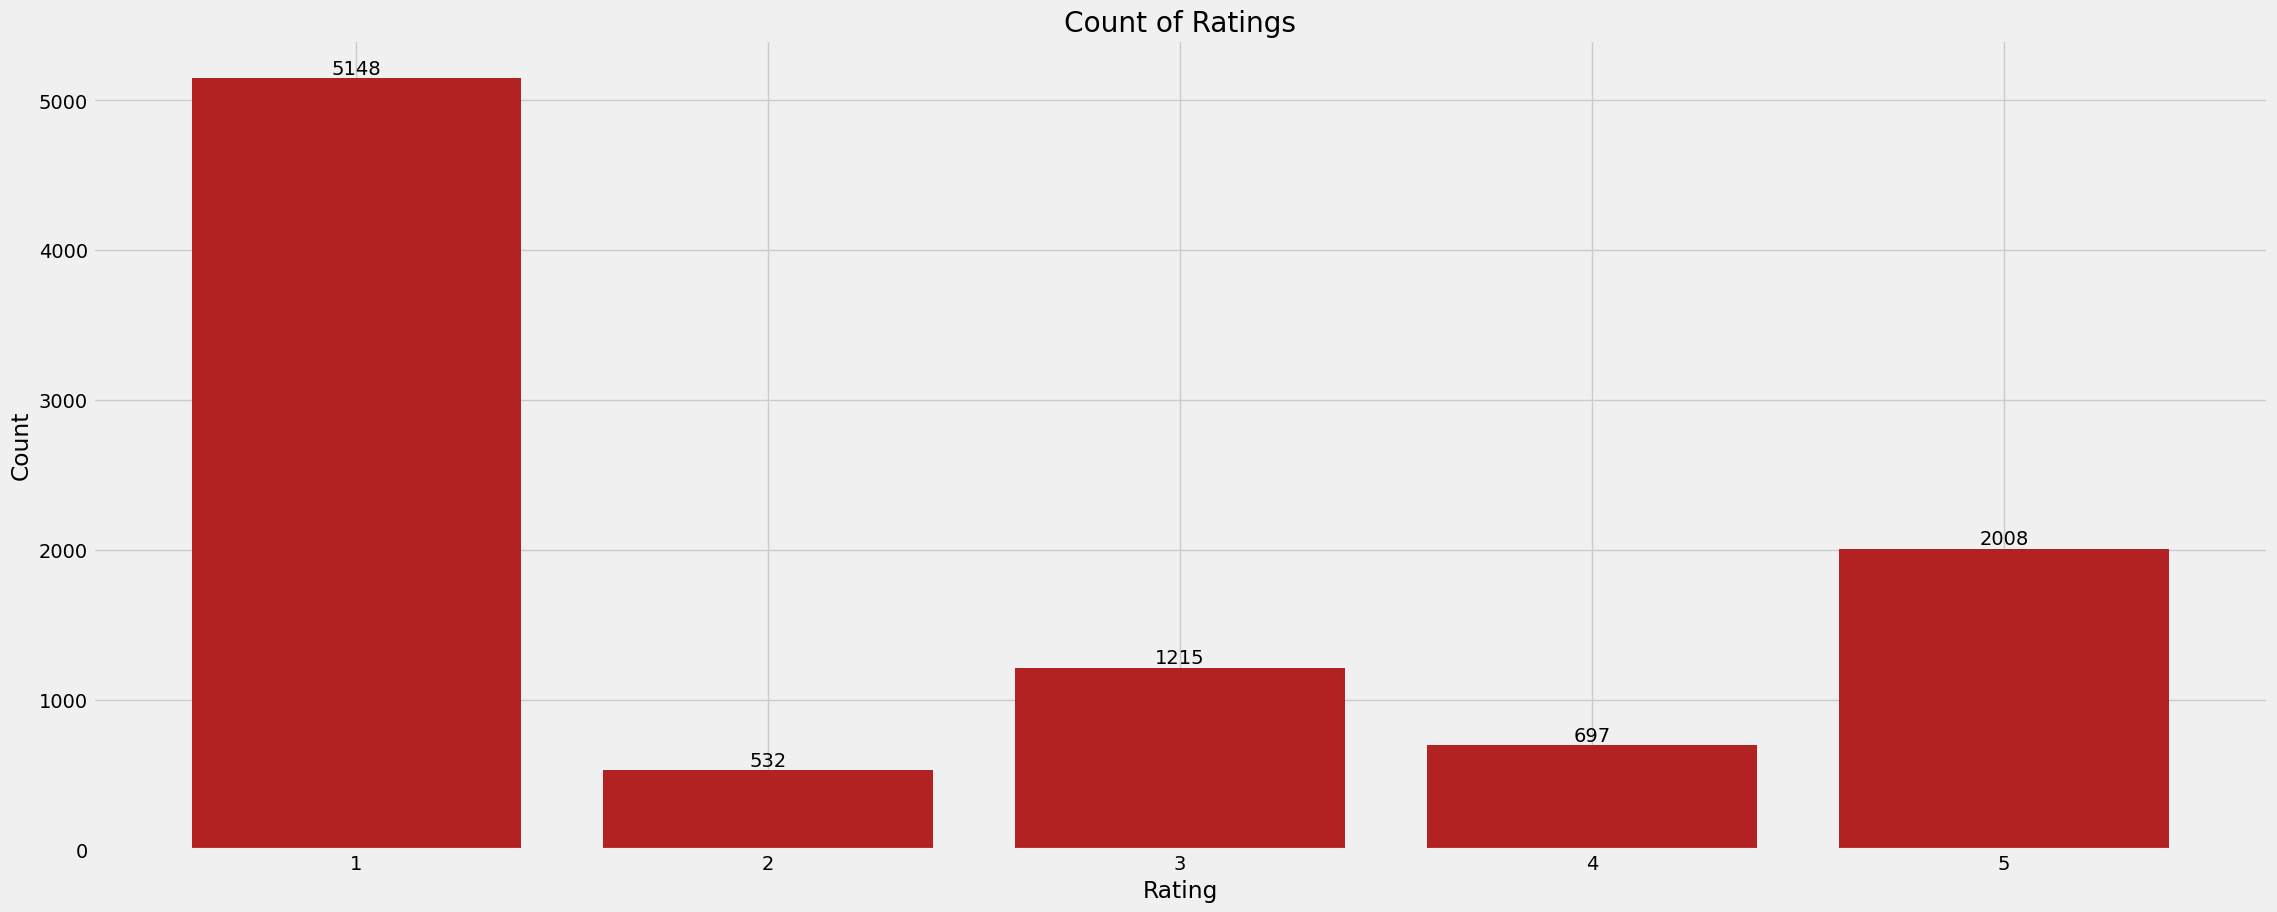

In [18]:
# This first visualization looks at the count of reviews.
# it can be seen that there are many 1 star reviews and many 5 star reviews.
# this is not a problem as I will not be exploring the relationship between variables, just the underlying text
plt.style.use('fivethirtyeight')
fix, ax = plt.subplots(figsize = (25, 10))

ratings = english_reviews['RATING'].value_counts()
ind = english_reviews['RATING'].unique()

plt.bar(ind, ratings, color = 'firebrick', align = 'center')

for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2,
            p.get_height(),
            '{:.0f}'.format(p.get_height()),
            ha='center',
            va='bottom'
           )

plt.title('Count of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

Text(0.5, 1.0, 'Number of words by review histogram')

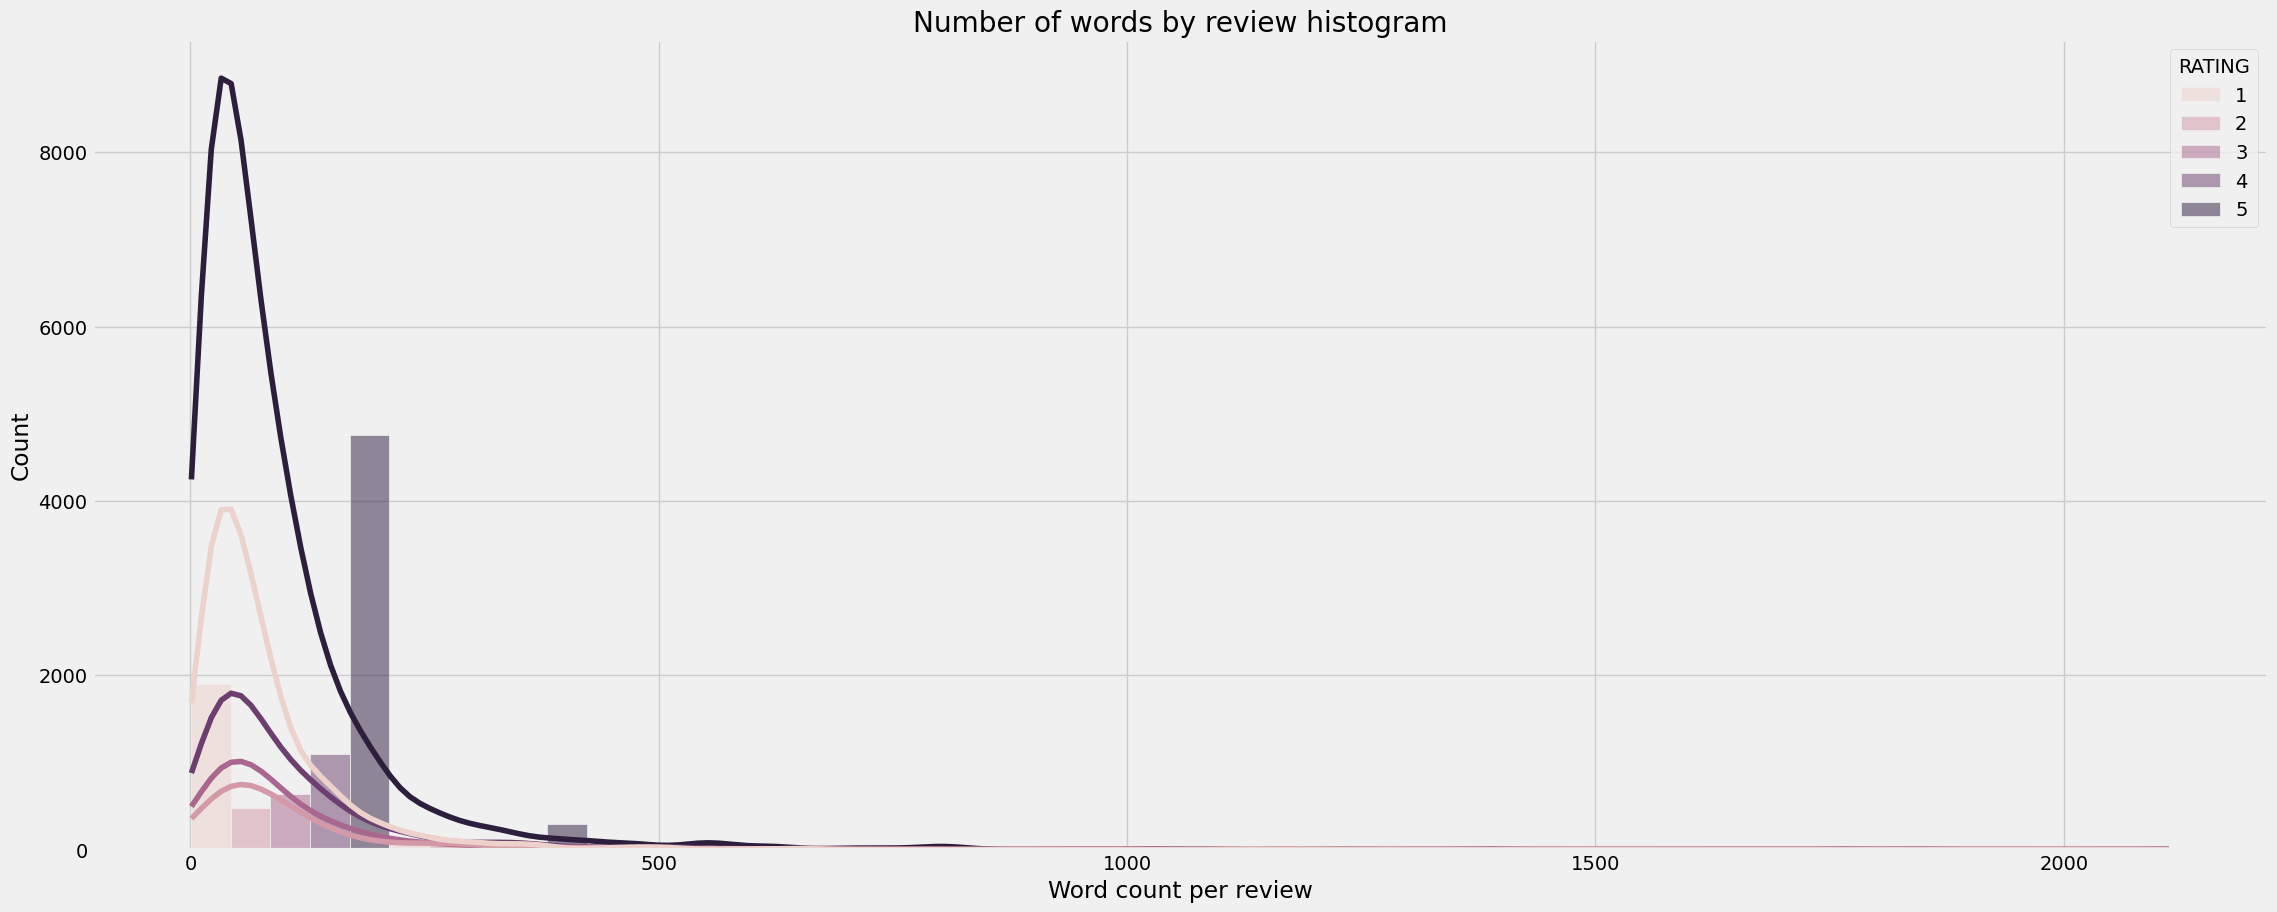

In [19]:
# The next visualization plots the distribution of the number of words in the review,
# separated by the rating of the review. It's interesting to see that the users who left a 5 star review
# left the longest reviews. 
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize = (25, 10))

sns.histplot(data=english_reviews, x='word_count', hue='RATING', multiple='dodge', legend='RATING', kde = True, bins = 10)

plt.xlabel('Word count per review')
plt.ylabel('Count')
plt.title('Number of words by review histogram')

/var/folders/lr/994tkpld58q9sbf0jsds90h80000gn/T/ipykernel_45493/549723031.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(data, labels = english_reviews['RATING'].unique(), patch_artist=True)


Text(0, 0.5, 'Word count')

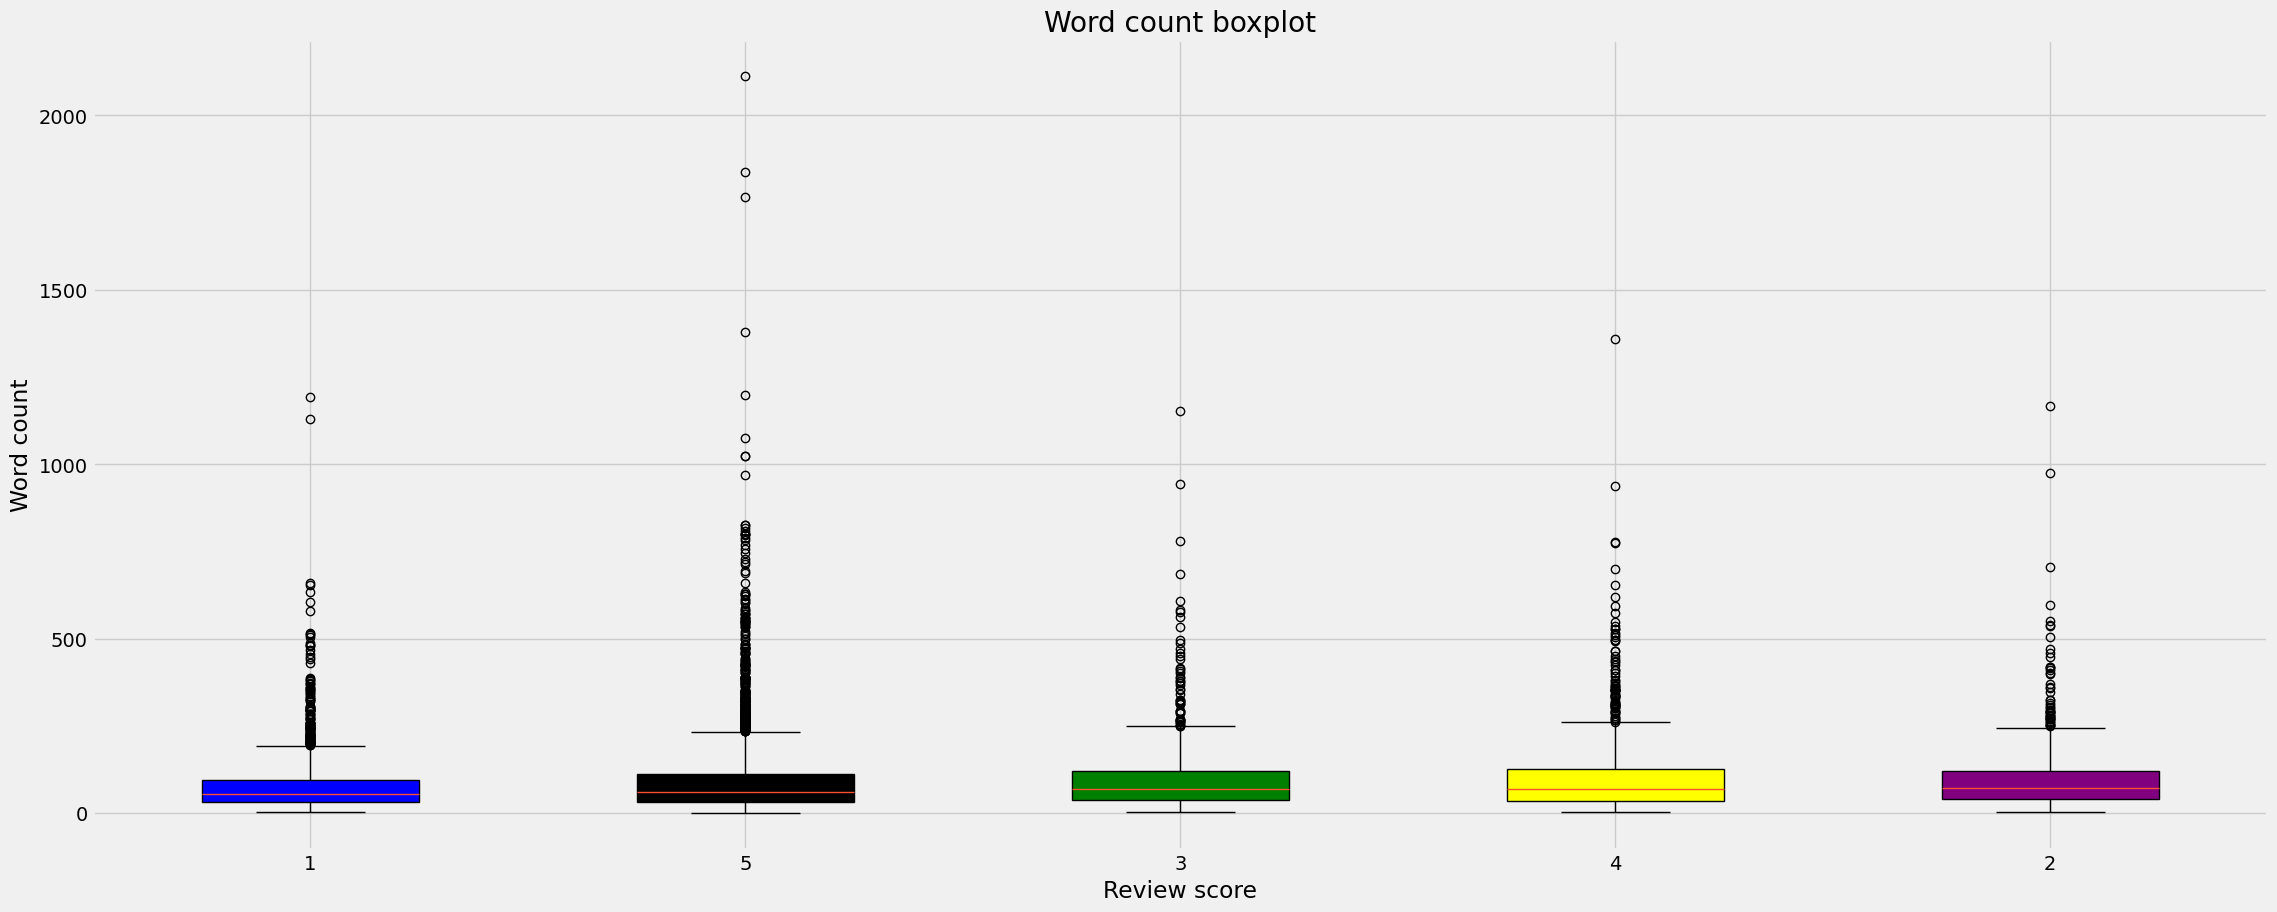

In [20]:
# here I am looking at the word count again, but in boxplot form. you can see the average review word count is
# a little less than 100, however there are major outliers, especially for the five star reviews.
# who has time to leave a 2112 word review?
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize = (25, 10))

wc_group = english_reviews.groupby('RATING')['word_count'].apply(list)
data = [wc_group[cat] for cat in english_reviews['RATING'].unique()]

bp = plt.boxplot(data, labels = english_reviews['RATING'].unique(), patch_artist=True)

colors = ['blue', 'black', 'green', 'yellow', 'purple']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

plt.title('Word count boxplot')
plt.xlabel('Review score')
plt.ylabel('Word count')

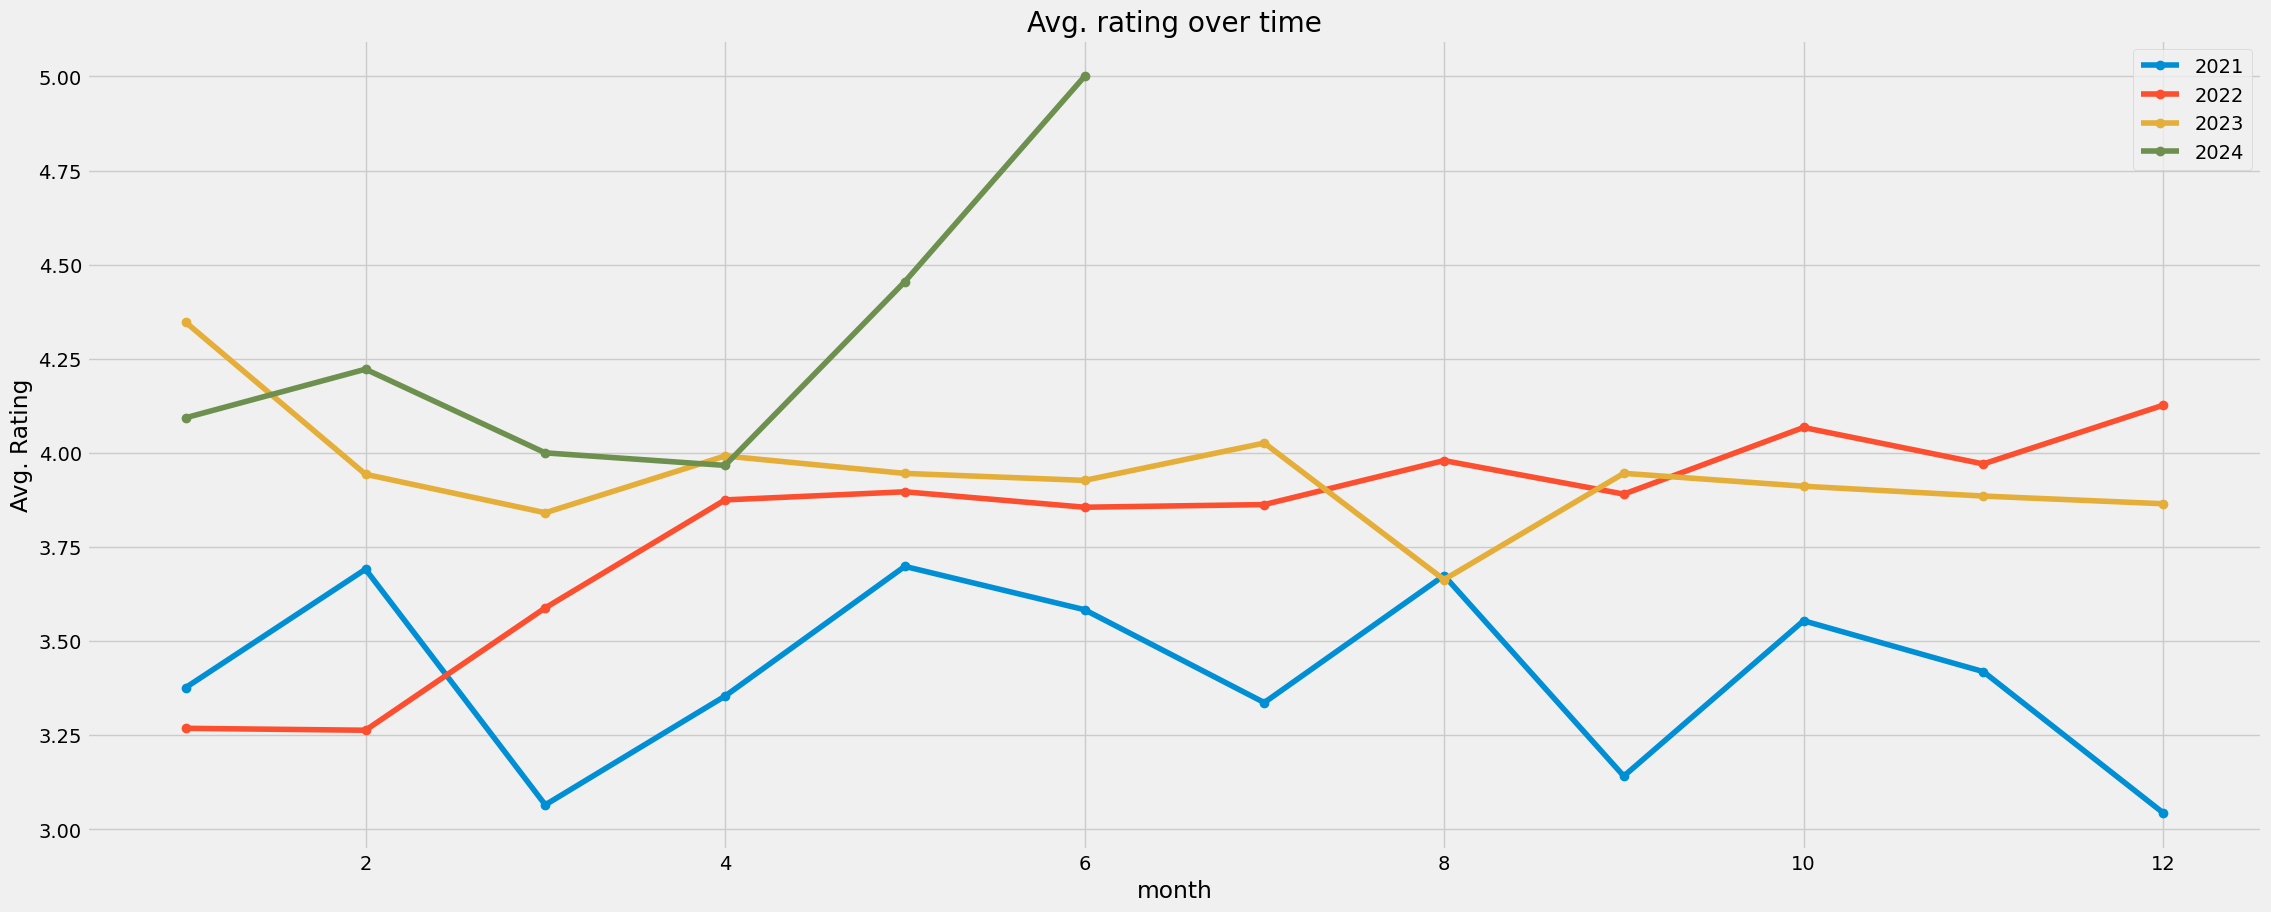

In [21]:
# does the year impact the average review? the graph below seems to indicate there is some evidence to suggest
# the year does impact the average review. why were people so angry online in 2021? the good news is that
# people leaving reviews seem to be pretty happy here in 2024
monthly_avg_rating = english_reviews.groupby(['YEAR', 'MONTH'])['RATING'].mean().reset_index()
filtered_rating = monthly_avg_rating[monthly_avg_rating['YEAR'].isin([2021, 2022, 2023, 2024])]
pivot_df = filtered_rating.pivot(index = 'MONTH', columns = 'YEAR', values='RATING')

plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize = (25, 10))

for col in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[col], marker = 'o', label = col)

plt.xlabel('month')
plt.ylabel('Avg. Rating')
plt.title('Avg. rating over time')
plt.legend()

In [22]:
# Here is a funny review I thought I would leave here...
pd.set_option('display.max_colwidth', None)
english_reviews['REVIEW_TEXT'].sample(1, random_state = 14)

7618    It is not a deluxe mix at all. It has only three Brazil nuts in the whole can with few pistachios. It is mostly just cashews and almonds. It is very deceiving and misleading, a total scam!
Name: REVIEW_TEXT, dtype: object

## Count Vectorize

In this section we will continue to prepare our dataset for the modeling phase later in this notebook. Before we can begin modeling, we will need to tokenize the dataset by using sklearn's CountVectorizer. This is an NLP preprocessing tool that takes a corpus of text as an input, breaks the document down into individual words, counts the unique inidividual words, and finally outputs numerical features that can be used in numerous machine learning models. The CountVectorize class is very important, and makes the job of a sentiment analysis much more simple.

In [23]:
# here I am removing all puncuation from the 'REVIEW_TEXT' field by creating quick function so our tokenizer (see the CountVectorizer function call a few cells down) splits
# the words accurately. There are probably other punctuation that I did not exclude
def remove_punctuation(text):
    final_text = []
    for row in text:
        clean_row = "".join(u for u in row if u not in ('?', '.', ';', ':', '!', '"', "'", '(', ')', '[', ']', '/', ',', '-', '*'))
        final_text.append(clean_row.lower())
    
    return final_text

In [24]:
# calling the remove_punctuation function from above 
english_reviews['REVIEW_TEXT'] = remove_punctuation(english_reviews['REVIEW_TEXT'])

/var/folders/lr/994tkpld58q9sbf0jsds90h80000gn/T/ipykernel_45493/4257076600.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_reviews['REVIEW_TEXT'] = remove_punctuation(english_reviews['REVIEW_TEXT'])


In [25]:
# one of the required inputs to the CountVectorizer is to define how the words should be broken up.
# This regex pattern breaks up all words and numbers by their whitespace
token = RegexpTokenizer(f'[a-zA-Z0-9]+')

In [26]:
# calling the CountVectorizer for both unigram and bigrams meaning that in the sentence 'I walked outside' not only will 'I',
# 'walked', 'outside' be counted but also 'I walked' and 'walked outside'. This will widen our dataset up quite a bit.
cv = CountVectorizer(stop_words = 'english', ngram_range = (1,2), tokenizer = token.tokenize)

In [27]:
# fit transforming the CountVectorizer to our 'REVIEWS_TEXT' column
# we are now ready to train test split our transformed dataset
text_counts = cv.fit_transform(english_reviews['REVIEW_TEXT'])

/Users/cman/Desktop/code/customer_reviews/.venv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


## Train Test Split

In [28]:
# train test splitting our modified dataset where 20% of the data will be witheld for the testing set.
# I also included teh 'stratify' input to ensure the same number of 'RATINGS' were balanced within the training and testing set.
X_train, X_test, Y_train, Y_test = train_test_split(text_counts, english_reviews['RATING'], test_size = 0.2, random_state = 42, stratify=english_reviews['RATING'])

## Training the MNB model 

In this first model, I aimed to create a Bag of Words Vectorization by using the CountVectorization that was completed in the previous cell. Now with our sparse matrix, we can apply this to a classification model. In this instance, I decided to use the MultinomialNB sklearn package which initializes a multinomial Naive Bayes classifier which will be able to predict the rating the user left based on their review text.

After calling the MultinomialNB class and fitting the model on the training data, we can predict on our testing data and obtain an accuracy score.  

It should be noted that to create a model such as this, you will need a labeled dataset.

In [29]:
# calling the MultinomialNB class and fitting the model on our training data
MNB = MultinomialNB()
MNB.fit(X_train, Y_train)

MultinomialNB()

In [30]:
# using our model to predict on our test data 
predicted = MNB.predict(X_test)

In [31]:
# using sklearn's accuracy_score to obtain an accuracy score for our predicted values vs. the actual Y_test values
acc_score = accuracy_score(predicted, Y_test)

In [32]:
# the model achieved an overall accuracy score of 61% which is ok
print(f'The accuracy score of the Multimodial Naive Bayes model is: {round(acc_score, 2)}')

The accuracy score of the Multimodial Naive Bayes model is: 0.61


In [33]:
# taking a look at the first 5 predicted values
predicted[:5]

array([5, 5, 5, 1, 5])

In [34]:
# and taking a look at the first 5 actual values
Y_test[:5]

5211    5
3223    1
8023    5
673     1
4012    5
Name: RATING, dtype: int64

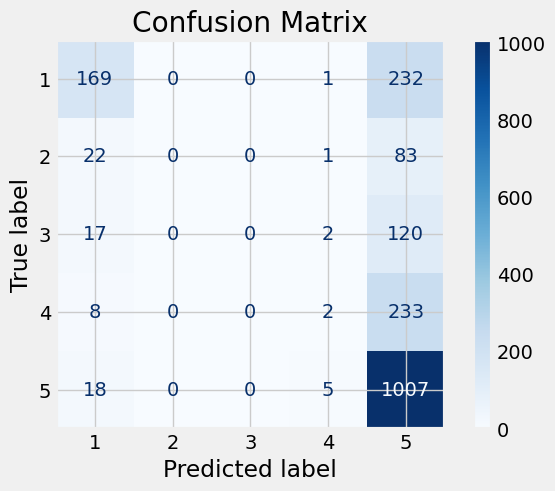

In [35]:
# buiding a confusion matrix to better understand the predictions that the model was making against the actual values.
# it seems the model predicted a lot of 5 star ratings, even when the review was quite negative.
cm = confusion_matrix(Y_test, predicted)

disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = np.unique(Y_test))
disp.plot(cmap = plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

### Text Blob

For the next model, I used a popular Python library used in Natural Language Processing called Text Blob. It is a pre-trained model that takes text as input, and outputs a 'polarity' and 'subjectivity' score. The polartiy determines the sentiment of the text. The 'polarity' output is on a scale from -1 to 1 and the 'subjectivity' output is on a scale from 0 to 1. For the 'polarity' output, a -1 means the review is highly negative and a 1 denotes a highly positive review. The subjectivity score determines whether a text input is fact vs personal information. A 0 denotes a fact and 1 denotes a personal opinion. We will be using the 'polarity' score to derive a prediction, but the 'polarity' score is still interesting to look into.

Using the Text Blob model is simple and only requires a few lines of code to get started.

In [36]:
# here is a review that we will use as a test for our Text Blob model
english_reviews['REVIEW_TEXT'].iloc[284]

'almost 2 months later abused daily and the 11 month old 90+ lb rottweiler puppy still hasnt made a dent in the kong tire no longer pleasantly surprised  amazingly surprisedi have a 10 month old rottweiler puppy that is a strong chewer he has destroyed 2 of the 10 inch pet store tire chews ive always had great experiences with kong products so i ordered this i picked the biggest one they had knowing that kong isnt afraid to make big dog toyswhen i received the tire and saw it was really no bigger than a good doughnut i was pssed to say the least being mail order i figured returning it would be more trouble than it was worth so i gave it to himhe loves it and can not destroy it i guess its big enough that it entices him but not big enough for him to get to its weak areas and destroy it i have not had a tire toy last this long at all let alone remain in like new conditionthanks kong from us and our little boy'

In [38]:
# calling TextBlob and passing it the sample review to output a 'polarity' and 'subjectivity' score.
p1 = TextBlob(english_reviews['REVIEW_TEXT'].iloc[284]).sentiment.polarity
s1 = TextBlob(english_reviews['REVIEW_TEXT'].iloc[284]).sentiment.subjectivity

In [39]:
# with a polarity score of 0.0725 and a subjectivitiy score of 0.3789, this implies the TextBlob model thinks this review is fairly neutral and is fairly personal information 
print(f'The polarity of the test token is : {round(p1, 4)} and the subjectivity of the test token is: {round(s1, 4)}')

The polarity of the test token is : 0.0725 and the subjectivity of the test token is: 0.3789


In [40]:
# in reality, the rating for this review was a 5. This is not quite what the TextBlob model would have output 
print(f'The actual rating was: {english_reviews['RATING'].iloc[284]}')

The actual rating was: 5


In [41]:
# now, to get a rating for each review in our dataset, we will utilize two functions to calculate both the 'polarity' and 'subjectivity' scores 
def calculate_polarity(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

def calculate_subjectivity(text):
    blob = TextBlob(text)
    return blob.sentiment.subjectivity

In [42]:
# creating new columns that will house the 'polarity' and 'subjectivitiy' raw values
english_reviews['TEXT_BLOB_POLARITY_RAW'] = english_reviews['REVIEW_TEXT'].apply(calculate_polarity)
english_reviews['TEXT_BLOB_SUBJECTIVITY_RAW'] = english_reviews['REVIEW_TEXT'].apply(calculate_subjectivity)

/var/folders/lr/994tkpld58q9sbf0jsds90h80000gn/T/ipykernel_45493/1798084721.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_reviews['TEXT_BLOB_POLARITY_RAW'] = english_reviews['REVIEW_TEXT'].apply(calculate_polarity)
/var/folders/lr/994tkpld58q9sbf0jsds90h80000gn/T/ipykernel_45493/1798084721.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_reviews['TEXT_BLOB_SUBJECTIVITY_RAW'] = english_reviews['REVIEW_TEXT'].apply(calculate_subjectivity)


In [43]:
# but how to normalize the TextBlob -1 to 1 scale to our 1 to 5 scale? An extra function is needed.
# here I am taking the TextBlob polarity value and applying some mapping logic so the new scale is from 1 to 5
def map_rating(value):
    mapped_value = (value + 1) * 2.5 + 0.5
    mapped_rating = round(mapped_value)
    mapped_rating = max(1, min(5, mapped_rating))
    return mapped_rating

In [44]:
# now using the function to create a new column for our mapped value
english_reviews['TEXT_BLOB_POLARITY_MAPPED'] = english_reviews['TEXT_BLOB_POLARITY_RAW'].apply(map_rating)

/var/folders/lr/994tkpld58q9sbf0jsds90h80000gn/T/ipykernel_45493/441747895.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_reviews['TEXT_BLOB_POLARITY_MAPPED'] = english_reviews['TEXT_BLOB_POLARITY_RAW'].apply(map_rating)


In [45]:
# taking a look at a sample row
english_reviews.sample(1)

,ID,REVIEW_DATE,IS_VERIFIED,RATING,REVIEW_TITLE,REVIEW_TEXT,COUNTRY,LANGUAGE,word_count,YEAR,MONTH,TEXT_BLOB_POLARITY_RAW,TEXT_BLOB_SUBJECTIVITY_RAW,TEXT_BLOB_POLARITY_MAPPED
4310,1010157,2013-01-22,True,5,Senseo o,senseo coffee is great however i think that the price continuing to rise will drive purchased for friend who was taken off regular coffeeshe does not notice the difference,United States,en,29,2013,1,0.4,0.413462,4


In [48]:
# with our mapped values and our TextBlob 'predictions' we can calculate the accuracy_score for this model
acc_score_2 = accuracy_score(english_reviews['TEXT_BLOB_POLARITY_MAPPED'].values, english_reviews['RATING'].values)

In [50]:
# with an overall accuracy score of 13%, the TextBlob model performed very poorly
print(f'The accuracy score of the \'Text Blob\' model accuracy score is: {round(acc_score_2, 4)}')

The accuracy score of the 'Text Blob' model accuracy score is: 0.1326


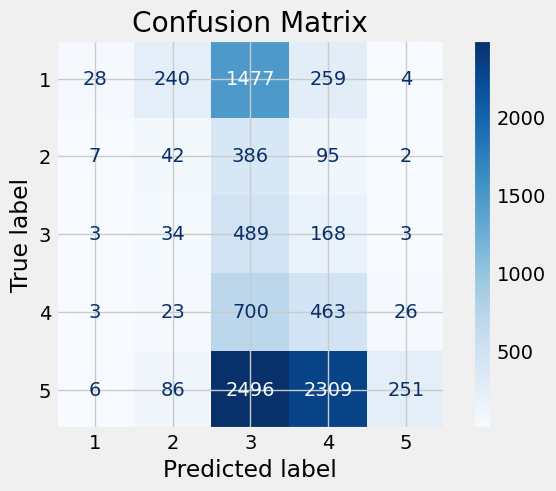

In [51]:
# buiding a confusion matrix to better understand the predictions that the model was making against the actual values.
# It seems like the model under predicted the ratings for many of the reviews. The model did seem to predict the 4 and 3 star reviews quite well however
cm = confusion_matrix(english_reviews['RATING'].values, english_reviews['TEXT_BLOB_POLARITY_MAPPED'].values)

disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = np.unique(Y_test))
disp.plot(cmap = plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

### VADER

For the final model, I am going to attempt to use a different pre-trained model to see if the score will improve. This next model is the Valence Aware Dictionary and Sentiment Reasoner (VADER) model that is a rule based sentiment analyzer. The model has been pre-trained on social media text and outputs a 'positive', 'negative', and 'neutral' rating which will equate to 1. An example can be seen in the next few cells.

Similarly to the Text Blob model, the VADER model is simple and only requires a few lines of code to get started.

In [54]:
# here we are initializing the VADER class
sentiment = SentimentIntensityAnalyzer()

In [52]:
# an test review we can use to demonstrate the VADER model output
t_1 = english_reviews['REVIEW_TEXT'].iloc[1336]
t_1

'well im a male not on hrt but trying to grow little bigger boobs and im taking a concoction of herbs just trying to get them a little bigger for the men'

In [55]:
# here is the output of the VADER model.
# the model would classify this as a moderate rating based on the review
sent_1 = sentiment.polarity_scores(t_1)
print(f'The VADER sentiment of review 1337 is: {sent_1}')

The VADER sentiment of review 1337 is: {'neg': 0.0, 'neu': 0.952, 'pos': 0.048, 'compound': 0.1406}


In [56]:
# The actual rating for this review was 5 stars. This is a pretty non-descipt review, so I don't dis-credit the model this time
print(f'The actual rating for review 1337 is: {english_reviews['RATING'].iloc[1336]}')

The actual rating for review 1337 is: 5


In [57]:
# similar to above, creating a quick function to run our reviews through
def calculate_sentiment(text):
    vader = sentiment.polarity_scores(text)
    return vader

In [58]:
# creating a new column to house the raw VADER values
english_reviews['VADER_SENTIMENT_RAW'] = english_reviews['REVIEW_TEXT'].apply(calculate_sentiment)

/var/folders/lr/994tkpld58q9sbf0jsds90h80000gn/T/ipykernel_45493/2277719038.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_reviews['VADER_SENTIMENT_RAW'] = english_reviews['REVIEW_TEXT'].apply(calculate_sentiment)


In [59]:
# taking a random review and looking at the output. you can see a new 'VADER_SENTIMENT_RAW' column
english_reviews.iloc[72]

ID                                                                                                   7822915
REVIEW_DATE                                                                              2016-01-14 00:00:00
IS_VERIFIED                                                                                             True
RATING                                                                                                     5
REVIEW_TITLE                                                                                      Five Stars
REVIEW_TEXT                   i use this with acrylic paint and it works and blends well it is worth the buy
COUNTRY                                                                                               Canada
LANGUAGE                                                                                                  en
word_count                                                                                                17
YEAR               

In [60]:
# similar to above, we will need to take the output of the VADER model and normalize it to our 1-5 star rating system.
# here I am only using the positive and negative values to create the mapping
def map_sentiment(sentiment):
    pos_score = sentiment['pos']
    neg_score = sentiment['neg']

    weighted_score = (pos_score - neg_score) * 2 + 3
    mapped_score = round(max(1, min(5, weighted_score)))
    return mapped_score

In [61]:
# the mapped rating for the example review above was 3 where the actual rating was 5
print(f'The mapped sentiment for review 1337 is: {map_sentiment(sent_1)}')

The mapped sentiment for review 1337 is: 3


In [62]:
# applying the mapping to the VADER raw output
english_reviews['VADER_SENTIMENT_MAPPED'] = english_reviews['VADER_SENTIMENT_RAW'].apply(map_sentiment)

/var/folders/lr/994tkpld58q9sbf0jsds90h80000gn/T/ipykernel_45493/3477691420.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_reviews['VADER_SENTIMENT_MAPPED'] = english_reviews['VADER_SENTIMENT_RAW'].apply(map_sentiment)


In [63]:
# calculating the accuracy for the VADER model mapped scores
acc_score_3 = accuracy_score(english_reviews['VADER_SENTIMENT_MAPPED'].values, english_reviews['RATING'].values)

In [64]:
# with an overall accuracy of 8% the VADER model performed worse than both the TextBlob and Bag of Words model.
# not impressed
print(f'The accuracy score of the \'VADER\' model accuracy score is: {round(acc_score_3, 4)}')

The accuracy score of the 'VADER' model accuracy score is: 0.0845


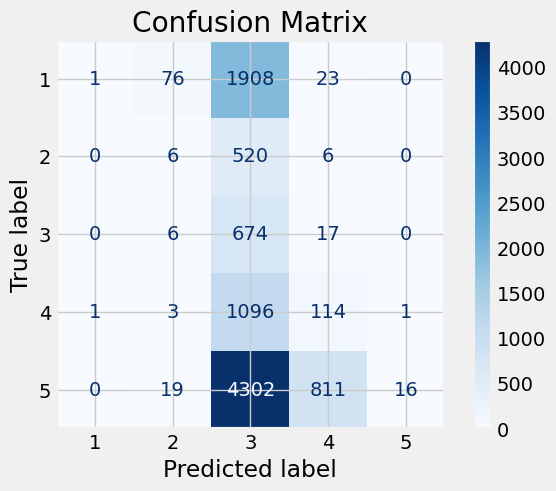

In [65]:
# buiding a confusion matrix to better understand the predictions that the model was making against the actual values.
# again, the VADER model underpredicted many of the reviews and predicted a lot of 3 stars which was often incorrect
cm = confusion_matrix(english_reviews['RATING'].values, english_reviews['VADER_SENTIMENT_MAPPED'].values)

disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = np.unique(Y_test))
disp.plot(cmap = plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

## Conclsion

In conclusion, throughout this notebook I completed an end to end sentiment analysis project from Amazon reviews left on numerous products in different categories. I began with some basic data cleanup, completed some EDA, completed fine tune prep to transform our data into a form that could be used in our machine learning model, then I created three different models (one utilizing the Bag of Words approach, and two distinct pre-trained models) and measured their respective accuracies. In the modeling phase, I was overall very impressed to see my Bag of Words model achieved the highest accuracy of all three models. I was not at all impressed with the two pre-trained models.

To further this research, I could have applied a TF-IDF approach in addition to the Multinomial Naive Bayes model to see if that approach would have resulted in a higher accuracy. I could have also built a more precise mapping function that may have increased the overall accuricies of the pre-trained models. With the limited time I had to complete this project, I'm happy with the results and felt like I learned a lot about NLP which I had no previous experience in. I would love to explore additional NLP datasets and modeling approaches in the future.